# Multiple-Network Representation Learning

## Aliens and Humans

Say you're a brain researcher, and you have a bunch of scans of brains - some are scans of people, and some are scans of aliens. You have some code that estimates networks from your scans, so you turn all your scans into networks. The nodes represent the brain regions which are common to both humans and aliens (isn't evolution amazing?), and the edges represent communication between these brain regions. You want to know if the human and alien networks share a common grouping of regions (your research topic is titled, "Do Alien Brains Have The Same Hemispheres That We Do?"). What do you do? How do you even deal with situations in which you have a lot of networks whose nodes all represent the same objects, but whose edges might come from totally different distributions?

Well, if your goal is to find the shared grouping of regions between the human and alien networks, you could try embedding your networks and then seeing what those embeddings look like. This would serve the dual purpose of having less stuff to deal with and having some way to directly compare all of your networks in the same space. For example, say you have nine alien networks and nine human networks. Since alien brain networks aren't currently very accessible, we'll just simulate our human and alien networks with Stochastic Block Models. The communities that we're trying to group all of the brain regions into are the two hemispheres of the brain. We'll design the human brains to have strong connections within hemispheres, and we'll design the alien brains to have strong connections between hemispheres -- but the same regions still correspond to the same hemispheres.

we'll use a relatively small number of nodes and fairly small block probabilities. You can see the specific parameters in the code below.

In [1]:
import warnings
import numpy as np
warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
import numpy as np
from graspologic.simulations import sbm

# Generate networks from an SBM, given some parameters
def make_sbm(*probs, n=100, return_labels=False):
    pa, pb, pc, pd = probs
    P = np.array([[pa, pb], 
                  [pc, pd]])
    
    return sbm([n, n], P, return_labels=return_labels)

# make nine human networks
# and nine alien networks
p1, p2, p3 = .12, .06, .03
n = 100
labels = [0]*n + [1]*n
humans = [make_sbm(p1, p3, p3, p1, n=n) for i in range(9)]
aliens = [make_sbm(p3, p1, p1, p3, n=n) for i in range(9)]

The edges of the human and alien networks come from very different distributions. As you can see from the Stochastic Block Model structure below, the regions in the human and the alien brains can both be separated into two communities. These communities represent the two hemispheres of the brain (who knew aliens also have bilateralized brains!). Although both humans and aliens have the same regions belonging to their respective hemispheres, as we planned, the alien networks have a strange property: their brain regions have more connections with regions in the opposite hemisphere than the same one.

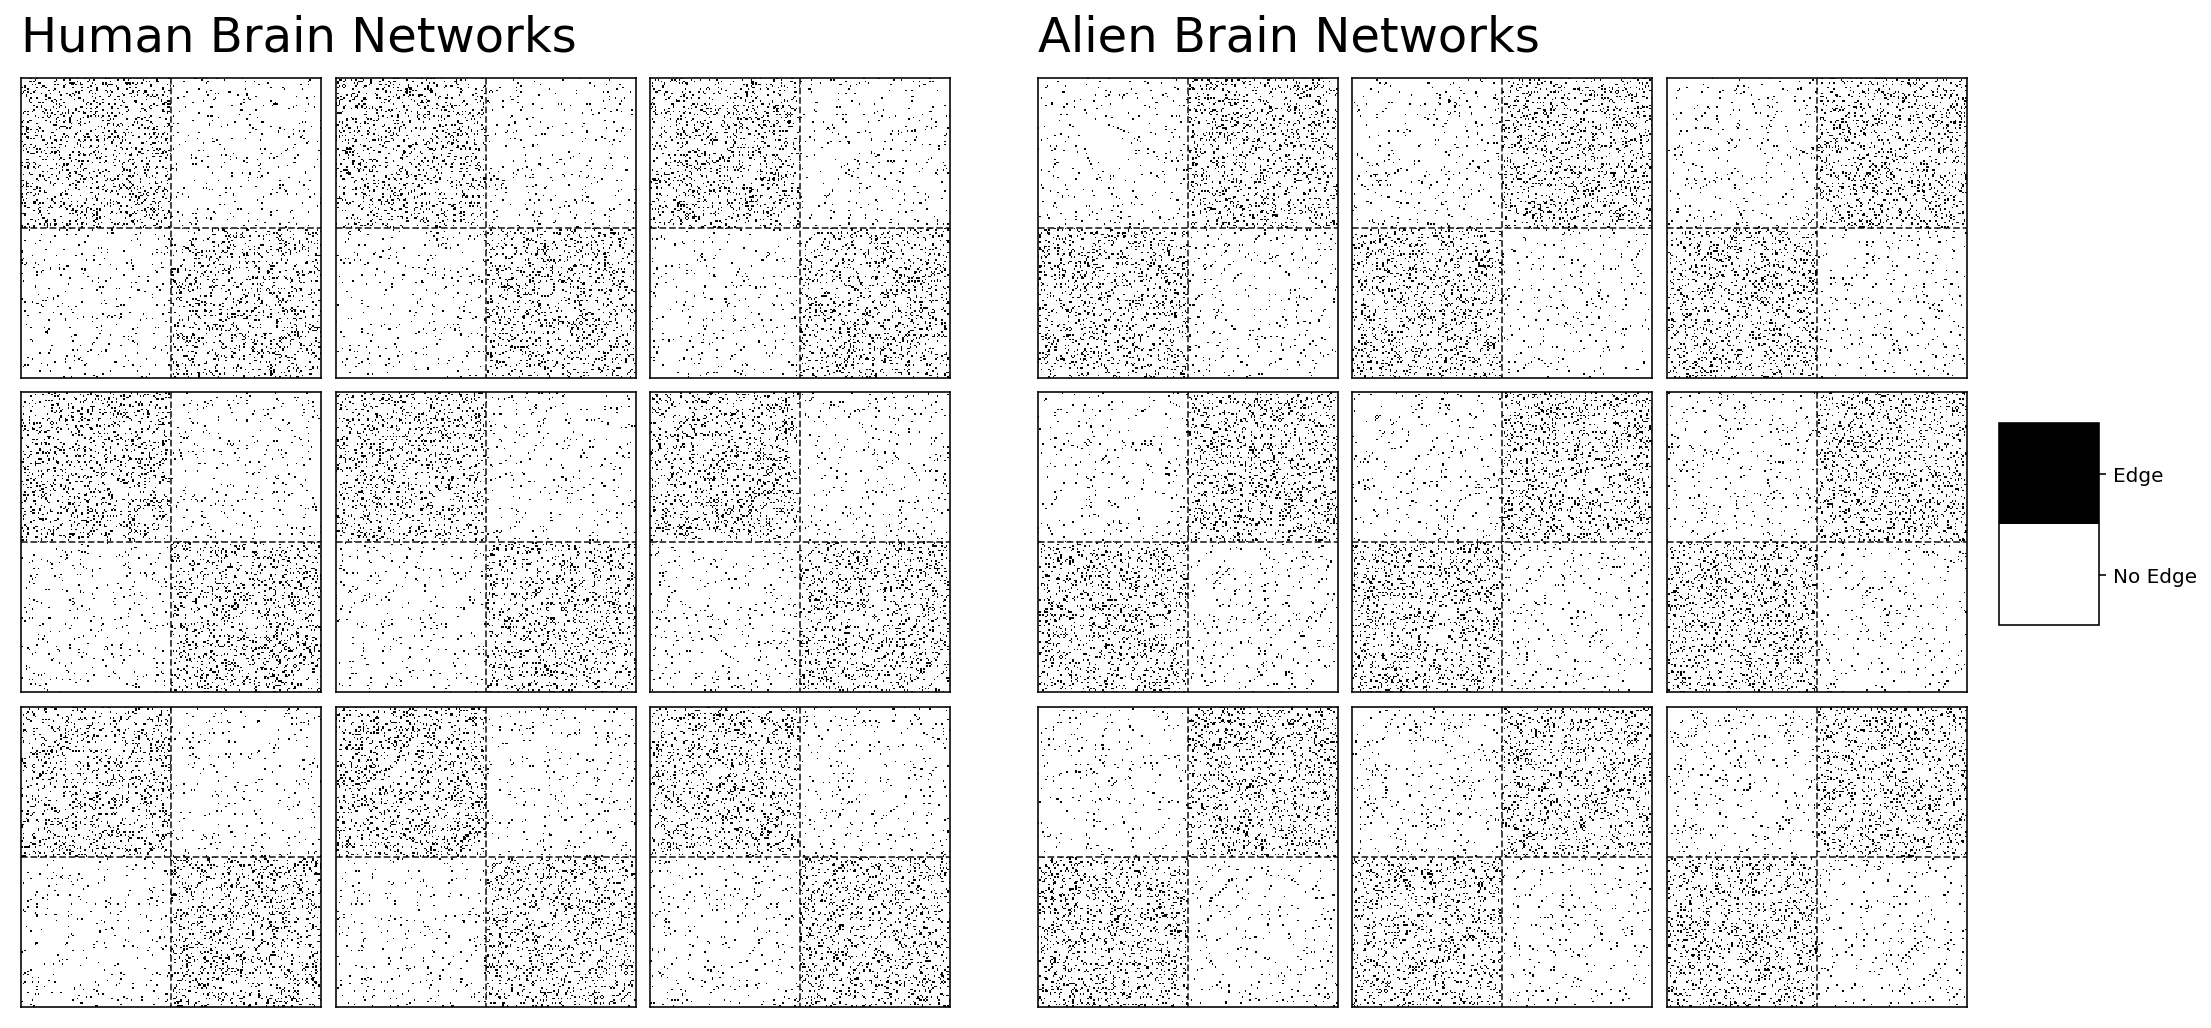

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from graspologic.plot import binary_heatmap, adjplot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%config InlineBackend.figure_format = 'retina'

def small_binary_heatmap(*args, **kwargs):
    ax = binary_heatmap(*args, **kwargs)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    return ax

def add_binary_cbar(im, rect=[1, 0.4, 0.05, 0.2], ax=None):
    fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    cmap = ListedColormap(["white", "black"])
    cax = fig.add_axes(rect)
    cbar = fig.colorbar(ax.imshow(im, cmap=cmap), cax=cax)
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(["No Edge", "Edge"])

fig = plt.figure(figsize=(14,7))

grid1 = ImageGrid(fig, 121, (3, 3), axes_pad=.1, share_all=True)
grid2 = ImageGrid(fig, 122, (3, 3), axes_pad=.1, share_all=True)

for i, (axi, axj) in enumerate(zip(grid1, grid2)):
    hmn = small_binary_heatmap(humans[i], ax=axi, legend=False, outline=True)
    hma = small_binary_heatmap(aliens[i], ax=axj, legend=False, outline=True)

grid1.axes_all[0].set_title("Human Brain Networks", fontsize=24, y=1.05, loc="left")
grid2.axes_all[0].set_title("Alien Brain Networks", fontsize=24, y=1.05, loc="left")

add_binary_cbar(humans[0])

plt.tight_layout(w_pad=3)

<AxesSubplot:>

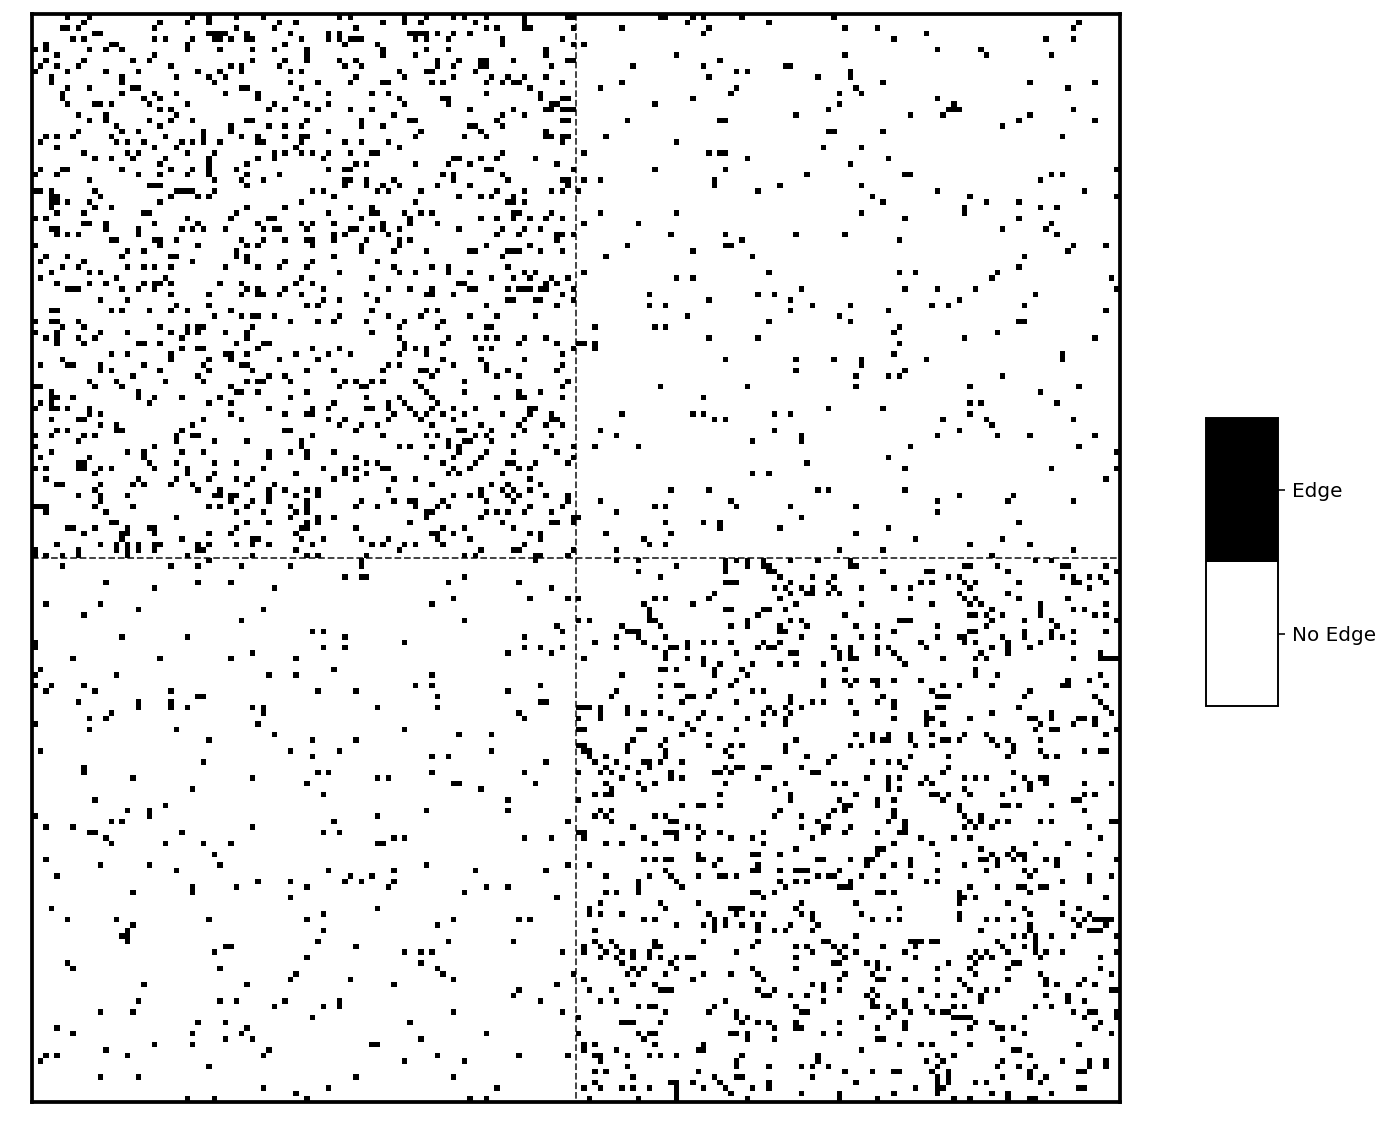

In [49]:
white_patch = mpatches.Patch(color='white', label='No Edge')
black_patch = mpatches.Patch(color='black', label='Edge')

small_binary_heatmap(humans[0])

## Different ways to do joint analysis

Remember, our goal is to find community structure common to both humans and aliens, and in our case that community structure is the brain hemispheres. We're going to try to to embed our brain networks into some lower-dimensional space - that way, we can use standard clustering methods from machine learning to figure out which regions are grouped. Try to think about how you might find a lower-dimensional embedding where the location of each node's latent positions uses information from all of the networks.

### Averaging Separately

The first idea you might come up with is to average your networks together, and then embed the result of that averaging with Spectral Embedding. It turns out that this is actually the right idea in the very special case where all of your networks come from the same probability distribution. In our case, averaging only the human networks together, and averaging only the alien networks together, will produce two separate embeddings with nicely clustered nodes.

In [37]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Compute the average adjacency matrix for 
# human brains and alien brains
human_mean_network = np.array(humans).mean(axis=0)
alien_mean_network = np.array(aliens).mean(axis=0)

# Embed both matrices
ase = ASE(n_components=2)
human_latents = ase.fit_transform(human_mean_network)
alien_latents = ase.fit_transform(alien_mean_network)

Below, you can see what happens when we embed the averaged human and alien networks separately. Like all of our embedding plots, each dot represents the latent positions for a particular node.

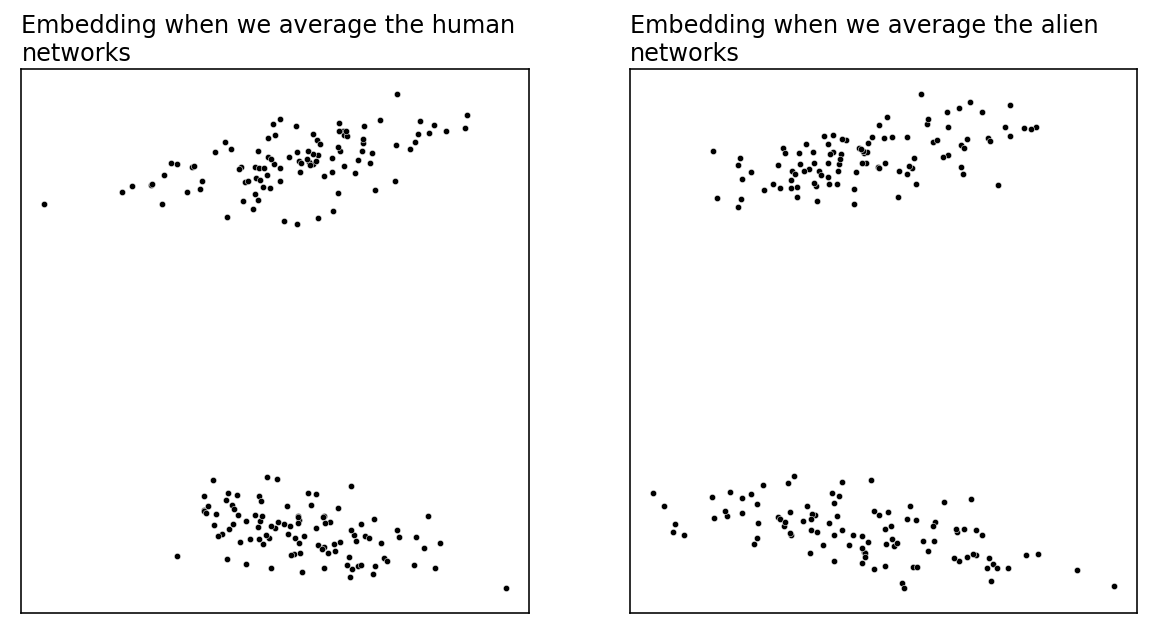

In [5]:
import seaborn as sns

def plot_latents(latent_positions, *, title=None, labels=None, ax=None, legend=True,
                 fontdict=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1", color='k', **kwargs)
    if title is not None:
        plot.set_title(title, wrap=True, fontdict=fontdict, loc="left");
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    h, _ = plot.get_legend_handles_labels()
    if legend and h:
        ax.legend(title="Community")
    elif not legend and np.any(labels):
        ax.get_legend().remove()
    
    return plot

# plot
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_latents(human_latents, title="Embedding when we average the human \nnetworks", ax=axs[0]);
plot_latents(alien_latents, title="Embedding when we average the alien \nnetworks", ax=axs[1]);

Both of these embeddings have clear clustering: there are two communities of nodes in both the human and the alien networks. We can recover the labels for these communities fairly easily using our pick of unsupervised clustering method. We know that the latent positions in each community of an Adjacency Spectral Embedding are normally distributed under this simulation setting, and we have two communities. That means that the above embeddings are distributed according to a Gaussian Mixture. Here, "Gaussian" just means "normal", and a gaussian mixture just means that we have groups of normally distributed data clusters. As a result, it makes sense to cluster these data using scikit-learn's GaussianMixture implementation. We'll also use graspologic's `remap_labels` utility function to make sure that index of the nodes matches for both our predicted alien and human labels.

In [6]:
from sklearn.mixture import GaussianMixture as GMM
from graspologic.utils import remap_labels

# Predict labels for the human and alien brains
human_labels = GMM(n_components=2).fit_predict(human_latents)
alien_labels = GMM(n_components=2).fit_predict(alien_latents)

# Make corresponding communities have the same values
alien_labels = remap_labels(human_labels, alien_labels)

You can see a plot that predicts our community structure below. Success! When we embed the human and the alien networks separately, averaging them clearly lets us cluster the brain regions by hemisphere. However, as you can see, the colors are flipped: the communities are in different places relative to each other. This is because the alien networks are drawn from a different distribution than the human networks. 

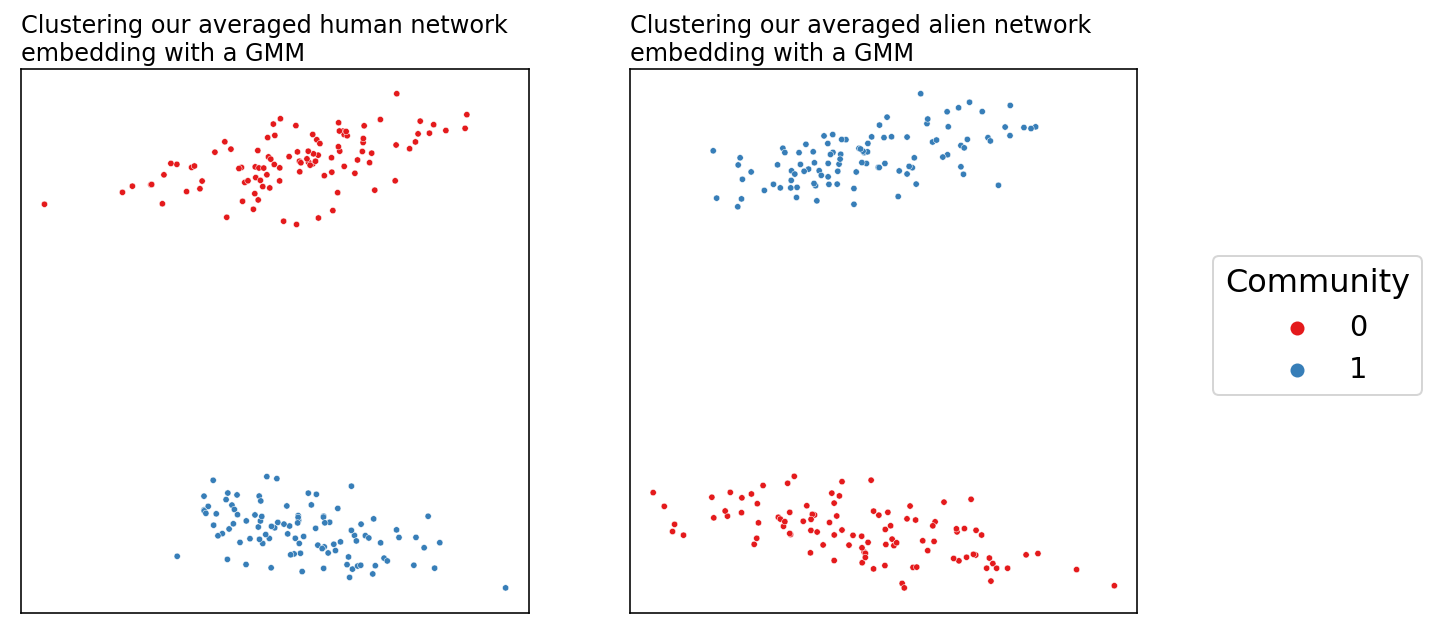

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_latents(human_latents, title="Clustering our averaged human network \nembedding with a GMM", 
             labels=human_labels, ax=axs[0], legend=False)
plot_latents(alien_latents, title="Clustering our averaged alien network \nembedding with a GMM", 
             labels=alien_labels, ax=axs[1], legend=False)

plt.legend(loc=(1.15, .4), fontsize="x-large", title="Community",
           title_fontsize=16);

### Averaging Together

But what if you wanted to embed *all* of the networks into the same space, both the human and the alien networks, so that there's only one plot? Let's try it. We'll take all of the networks and then average them together, and then do an Adjacency Spectral Embedding. This will result in a single plot, with each point representing a single brain region. Do you think we'll still find this nice community separation?

In [8]:
total_mean_matrix = np.array(humans + aliens).mean(axis=0)
all_latents = ase.fit_transform(total_mean_matrix)

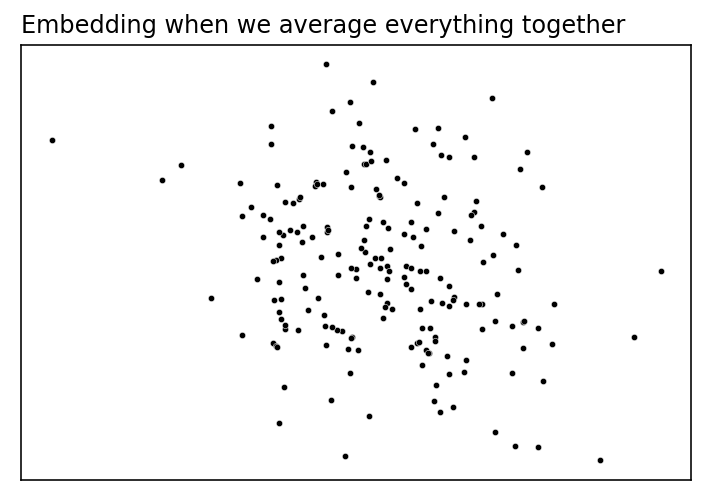

In [9]:
plot_latents(all_latents, title="Embedding when we average everything together");

Nope, bummer. Our community separation into discrete hemispheres is gone - the human networks and the alien networks cancelled each other out. As far as anybody can tell, our latent positions have just become meaningless noise, so we can't cluster and find communities like we did before.

#### Why Did Averaging Together Fail?

Why did this happen? Well, let's go back and compare one human brain network with one alien brain network.

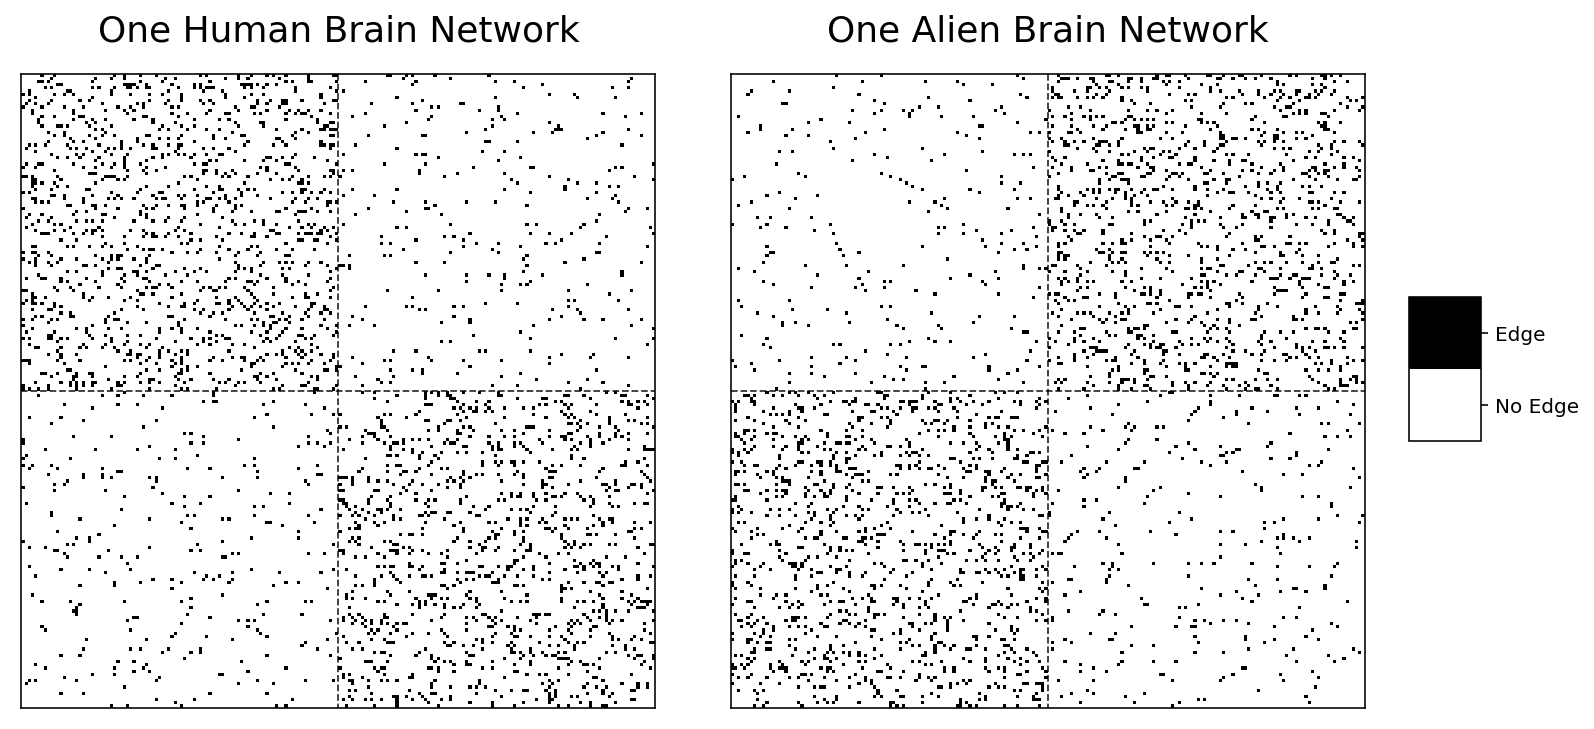

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
hmn = small_binary_heatmap(humans[0], ax=axs[0], legend=False, title="One Human Brain Network")
hma = small_binary_heatmap(aliens[0], ax=axs[1], legend=False, title="One Alien Brain Network")

add_binary_cbar(humans[0])
plt.tight_layout()

The human network has more edges in the upper-left and lower-left quadrants of the heatmap. This implies that two regions in the same hemisphere are more likely to be connected for humans than two regions in opposite hemispheres.

The alien network tells a different story. For aliens, two regions in opposite hemispheres are more likely to be connected than two regions in the same hemisphere.

But what happens when you average these two adjacency matrices together?

In [11]:
combined = np.array([humans[0], aliens[0]])
averaged = np.mean(combined, axis=0)

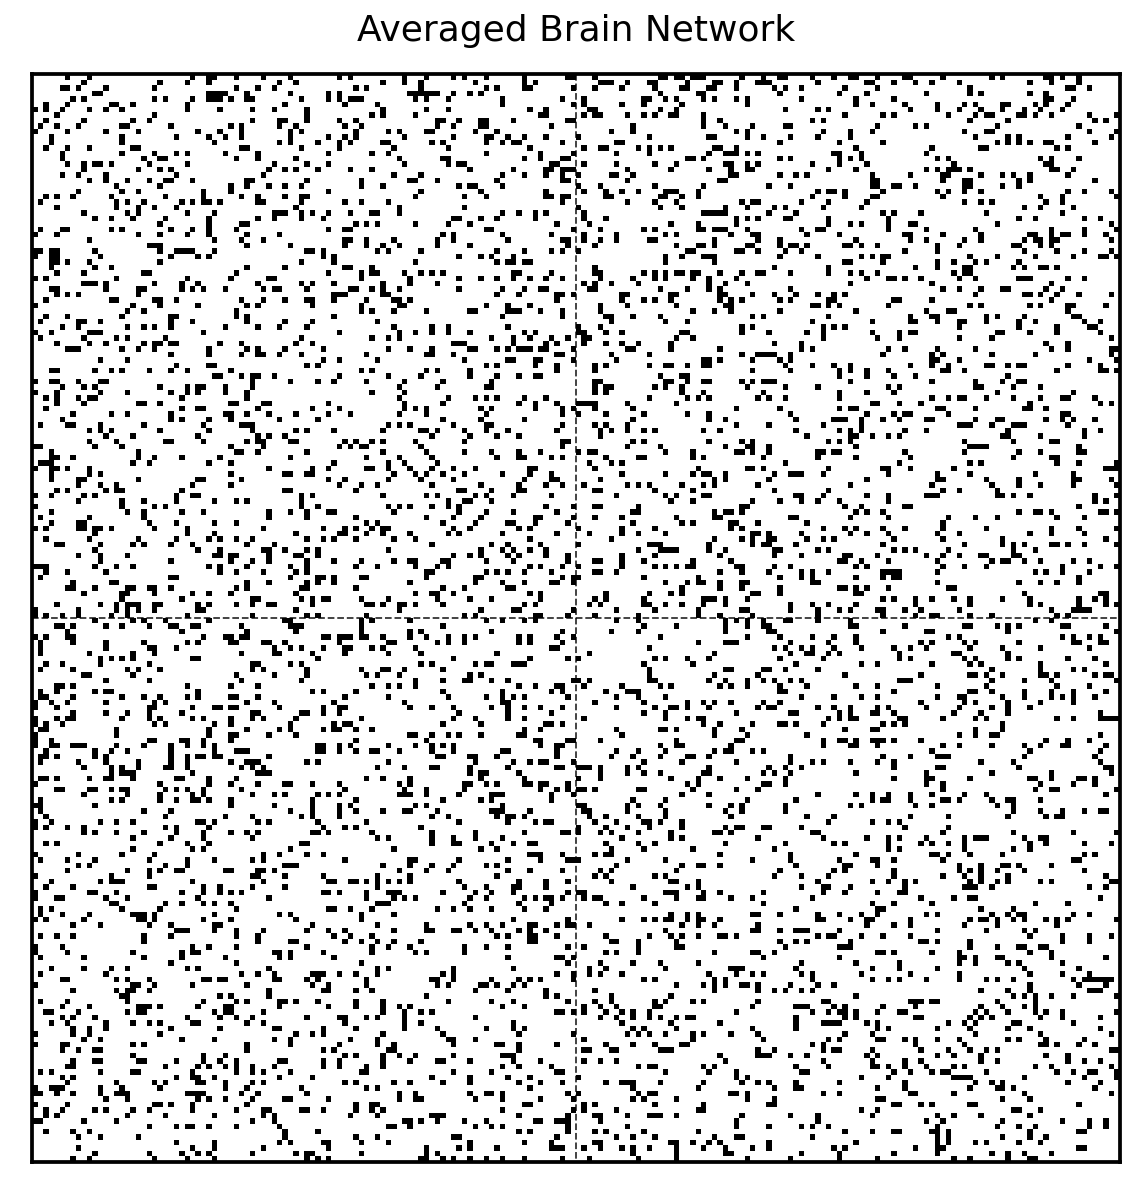

In [48]:
hm = small_binary_heatmap(averaged, title="Averaged Brain Network", legend=False);

By averaging, we've lost all of the community structure used to exist. That's why our big averaged embedding failed. 

We've just discovered that even though it's a great idea to simply average all of your networks together if they were drawn from the same distribution, it's often a horrible idea to average all of your networks if they might come from different distributions. This is a case of averaging networks which are "heterogeneous": Not only are your networks slightly different, but they're *expected* to be different because, again, they're drawn from different distributions. Sampling a lot of heterogenous networks and then averaging them, as you can see from our exploration above, can result in losing the community signal you might have had.

We'd like to find a way to compare these heterogeneous networks directly, so that we can embed all of our networks into the same space and still keep that nice community structure. Figuring out the best way to do this is a topic under active research, and the set of techniques and tools that have developed as a result are together called multiple-network representation learning.

## Different Types of Multiple-Network Representation Learning

TODO: add omni

Let's take a moment to explore some of the possible general approaches we could take in multiple-network representation learning. At some point we need to combine the many individual representations of our networks into one, and there are at least three possible places where we could do this: combining the networks, **omni one**, and combining the embeddings. Each of these eventually results in a latent position representation for our networks. It's important to note that in all of these approaches, we're simply learning representations for our groups of networks. You can do whatever you want with these representations; in our case, we'll illustrate that we can use them to classify our nodes.

### Combining the networks

TODO: add more info

With this approach, you'll start with a set of networks, and then you'll combine them all into a single network prior to doing anything else. You can then embed and classify this network directly. What we did before, averaging the human and alien networks, was an example of combining our networks -- we just averaged all of our adjacency matrices, and then we embedded the result.

In [ ]:
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed.omni import _get_omni_matrix
from graspologic.plot import heatmap

fig = plt.figure()

def rm_ticks(ax, **kwargs):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    sns.despine(ax=ax, **kwargs)
    
fig = plt.figure();

# add stack of heatmaps
for i in range(5):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = binary_heatmap(humans[i], ax=ax, legend=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
omni_ax = fig.add_axes([1, -.02*3, .8, .8])
A = _get_omni_matrix(humans+aliens)
a_hm = heatmap(A, ax=omni_ax, cbar=False)
a_hm.set_title("Joint Matrix", loc="left", fontsize=16)
for _, spine in a_hm.spines.items():
    spine.set_visible(True)
    
# add second arrow
arrow_ax = fig.add_axes([1.75, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add omni embedding
latents_omni = OMNI(n_components=2).fit_transform(humans+aliens).mean(axis=0)
omni_embed_ax = fig.add_axes([2.1, -.02*3, .55, .8])
plot_latents(latents_omni, ax=omni_embed_ax, title="Joint Embedding", 
             fontdict={'fontsize': 16})
rm_ticks(omni_embed_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([2.7, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
labels_normal = GMM(n_components=2).fit_predict(human_latents)
mase_ax = fig.add_axes([3.05, -.02*3, .55, .8])
plot_latents(latents_omni, ax=mase_ax, title="Classification", 
             fontdict={'fontsize': 16}, labels=human_labels, legend=False)

plt.suptitle("Combining the Networks", x=2, y=1.1, fontsize=26);

### Omni one

### Combining the embeddings

The final approach to multiple-network representation learning that we'll talk about is combining the embeddings themselves. With this approach, you're waiting until you've already embnedded all of your networks separately before you combine them, either with Adjacency Spectral Embedding or with some other single-network embedding method. Multiple Adjacency Spectral Embedding, another algorithm we'll be learning about later in this chapter, is an example of the Embedding Product approach.

In [ ]:
fig = plt.figure()

# add stack of heatmaps
for i in range(5):
    ax = fig.add_axes([.02*i, -.02*i, .5, .5]) 
    ax = binary_heatmap(humans[i], ax=ax, legend=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="right")
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# add arrow
arrow_ax = fig.add_axes([.5, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add stack of latent plots
for i in range(5):
    ax = fig.add_axes([.8+.02*i, -.02*i, .35, .5])
    if i == 0:
        ax.set_title("Separate Embeddings")
    latents = ase.fit_transform(humans[i])
    plot = sns.scatterplot(latents[:, 0], latents[:, 1], 
                       s=10, ax=ax, color="black")
    rm_ticks(ax, top=False, right=False)
    
# add second arrow
arrow_ax = fig.add_axes([1.25, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add group embeddings
mase = MASE(n_components=2)
latents_mase = mase.fit_transform(humans + aliens)
mase_ax = fig.add_axes([1.57, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Joint Embedding")
rm_ticks(mase_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([1.95, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
labels_normal = GMM(n_components=2).fit_predict(human_latents)
mase_ax = fig.add_axes([2.27, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Classification", 
             labels=labels_normal, legend=False)

plt.suptitle("Combining the Embeddings", x=1.4, y=.7, fontsize=20);

For the rest of this section, we'll explore the strengths and weaknesses of different particular techniques which use these approaches. Multiple Adjacency Spectral Embedding (MASE) is a technique which combines embeddings by concatennating and re-embedding the separate latent positions into a single space. MASE is nice because you don't actually need each network to be generated from the same distribution - you only need the nodes of the different networks to be aligned and for them to belong to the same communities. Omnibus embedding combines the adjacency matrix of all of the matrices into a single super-matrix, and then embeds that super-matrix.

## Multiple Adjacency Spectral Embedding

MASE is probably the easiest to understand if you know how Adjacency Spectral Embeddings work. Say you have some number of networks, and (like we said above) their nodes are aligned. The goal of MASE is to embed the networks into a single space, with each point in that space representing a single node - but, unlike simply averaging, MASE lets you combine networks which aren't necessarily drawn from the same distribution. MASE is based on the common subspace independent-edge (COSIE) model from the multi-network models section of chapter 5, so we're operating under the assumption that there *is* some low-dimensional space common to all of our networks that we can embed into in the first place.

Let's go back to our group of human and alien brains and try using MASE to embed them rather than averaging. Then, we'll dive deeper into what's going on under the hood. First, we'll instantiate a MASE classifier and embed down to two dimensions. Then we'll create a combined list of the human and alien brains, and use MASE to find the latent positions.

In [ ]:
from graspologic.embed import MultipleASE as MASE

# Use MASE to embed everything
mase = MASE(n_components=2)
latents_mase = mase.fit_transform(humans + aliens)

In [ ]:
plot_latents(latents_mase, 
             title="Embedding when we use MASE on the group \nof all human and alien networks", 
             labels=labels);

Unlike the disastrous results from simply averaging all of our networks together, MASE manages to keep the community structure that we found when we averaged our networks separately. Let's see what's under the hood.

### How Does MASE Work?

Below, you can see how MASE works. We start with networks, drawn as nodes in space connected to each other. We turn them into adjacency matrices, and then we embed the adjacency matrices of a bunch of networks separately, using our standard Adjacency Spectral Embedding algorithm. Then, we take all of those embeddings, concatenate horizontally into a single matrix, and embed the entire concatenated matrix. The colors are the true communities each node belongs to: there's a red and an orange community. MASE is an unsupervised learning technique and so it doesn't need any information about the true communities to embed, but they're useful to see.

```{figure} ../../Images/mase1.jpeg
---
height: 400px
name: mase-fig
---
The MASE algorithm
```

#### A Collection of Networks

We'll illustrate what's happening in the MASE algorithm by running through all of its steps ourselves, with a set of example networks.

Suppose we have a set of networks generated from Stochastic Block Models with two communities in each network. The networks have aligned nodes -- meaning that the $i_{th}$ row of all of their adjacency matrices represent the edges for the same node $i$. The nodes also all belong to the same communities. However, edge probabilities might change depending on the network. In the first network, you might have nodes in the same community having a high chance of connecting to each other, whereas in the second network, nodes are much more likely to be connected to other nodes in different communities. You want to end up with a classification that distinctly groups the nodes into their respective communities, using the information from all of the networks. Because MASE takes approach of combining the embeddings, we start by embedding each network separately with an Adjacency Spectral Embedding.

Below is Python code which generates four networks with Stochastic Block Models. Each of the networks is drawn from a different distribution (the block probability matrices are different), but the labels are the same across the networks (which means that nodes have a consistent community no matter which network you're looking at). If you're interested in the particular parameters used to generate these SBMs, you can see them in the code below.

In [ ]:
import numpy as np
from graspologic.simulations import sbm

n = 100
p1, p2, p3 = .12, .06, .03
A1, labels = make_sbm(p1, p3, p3, p1, 
                      return_labels=True)
A2 = make_sbm(p1, p3, p3, p2)
A3 = make_sbm(p3, p2, p2, p3)
A4 = make_sbm(p1, p3, p3, p3)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7,7))
for i, (ax, graph) in enumerate(zip(axs.flat, [A1, A2, A3, A4])):
    hmap = binary_heatmap(graph, ax=ax, legend=False, title=f"network {i+1}")
    for spine in ax.spines.values():
        spine.set_visible(True)
    hmap.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    hmap.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    
plt.suptitle("Four different networks", fontsize=26, y=1)
fig.subplots_adjust(hspace=.05, wspace=.05)

add_binary_cbar(A1)

plt.tight_layout()

#### Embedding our networks

Next, we embed each of the four networks separately using Adjacency Spectral Embedding. This step is pretty straightforward, so we won't dive into it too much: remember, we're combining the embeddings, not the networks, so we're not doing anything fancy. The python code below just groups the four networks into a list, and then loops through the list, embedding each network into two dimensions and saving the resulting embeddings into a variable.

In [ ]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

networks = [A1, A2, A3, A4]
latents = []
for network in networks:
    ase = ASE(n_components=2)
    latent = ase.fit_transform(network)
    latents.append(latent)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents[i], title=f"Embedding for network {i+1}", 
                 labels=labels, ax=ax, legend=False)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.suptitle("Embeddings of our four networks", fontsize=20);

h, l = ax.get_legend_handles_labels()
fig.legend(h, l, loc='center right', bbox_to_anchor=(1.25, .5), 
           prop={'size': 15}, title="Community", title_fontsize='x-large');

fig.supxlabel("Dimension 1")
fig.supylabel("Dimension 2");

plt.tight_layout()

#### Combining our embeddings

Now comes the interesting part. Our goal is to find some way to take each of these individual embeddings and combine them. We want to find a reasonable way of doing this.

We can visualize each of our four embeddings a different way. Instead of the using the two latent position dimensions as the x-axis and the y-axis of our plot, we can just visualize our latent position matrices directly. Each latent position now corresponds to rows in one of these matrices. The two columns are the two latent position dimensions, and the two colors in each row corresponds to the latent position value. We're essentially substituting location for color.

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = 'rocket_r'
fig, axs = plt.subplots(ncols=4, figsize=(16, 8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    hm = sns.heatmap(latents[i], cmap=cmap, 
                     ax=ax, yticklabels=50, cbar=False)
    hm.set_title(f"Embedding for network {i+1}", fontdict={'fontsize': 10})
    
fig.supxlabel("Dimension", x=.42, fontsize=16)
fig.supylabel("Latent Position", x=.005, fontsize=16)
fig.suptitle("Latent position matrices for our four embeddings", x=.42, fontsize=20)

fig.tight_layout(w_pad=2)
vmin, vmax = np.array(latents).min(), np.array(latents).max()
norm = Normalize(vmin=vmin, vmax=vmax)
im = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(im, ax=axs);

Because the rows of these matrices are all aligned - meaning, row 0 corresponds to node 0 for all four matrices - we can actually think of each node as having (in this case) eight latent position dimensions: two for each of our four networks. Eight is a somewhat arbitrary number here: each network contributes two dimensions simply because we originally chose to embed all of our networks down to two dimensions with ASE, and the number of networks is of course even more arbitrary. You'll usually have more than four.

In the more general sense, we can think of each node as having $m \times d$ latent position dimensions, where $m$ is the number of networks, and $d$ is the number of dimensions we embed each network into. We don't actually need separate matrices to express this idea: the natural thing to do would be to just concatenate all of the matrices horizontally into a single $m \times d$ matrix.

In [ ]:
from graspologic.embed import selectSVD

# Concatenate our four matrices horizontally into a single m by d matrix
concatenated = np.hstack(latents)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
hm = sns.heatmap(concatenated, cmap=cmap, ax=ax, yticklabels=50);
hm.set_title(f"Combined embedding for all four networks", fontdict={'fontsize': 20});
hm.set_xlabel("Dimension", fontsize=16)
hm.set_ylabel("Latent Position", fontsize=16);

#### Embedding our Combination To Create a Joint Embedding

So now we have a combined representation for our separate embeddings, but we have a new problem: our latent positions suddenly have way too many dimensions. In this example they have eight (the number of columns in our combined matrix), but remember that in general we'd have $m \times d$. This somewhat defeats the purpose of an embedding: we took a bunch of high-dimensional objects and turned them all into a single high-dimensional object. Big whoop. We can't see what our combined embedding look like in euclidean space, unless we can somehow visualize $m \times d$ dimensional space (hint: we can't). We'd like to just have `d` dimensions - that was the whole point of using `d` components for each of our Adjacency Spectral Embeddings in the first place!

There's an obvious solution here: why don't we just embed *again*? Nothing stops us from doing a Singular Value Decomposition on a nonsquare matrix, and so we can just create a joint embedding of our combined matrix and go back down to a healthy $d$ columns.

In [ ]:
joint_embedding, *_ = selectSVD(concatenated, n_components=2)

In [ ]:
from matplotlib.gridspec import GridSpec

# TODO: add legend
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 3)
axm = fig.add_subplot(gs[0])
axs = fig.add_subplot(gs[1:])

# Matrix representation
hm = sns.heatmap(joint_embedding, cmap=cmap, ax=axm, yticklabels=50, cbar=True,
                 cbar_kws={"shrink": .91})
hm.set_title(f"Matrix visualization of our \nJoint Embedding", fontdict={'fontsize': 14}, loc='left')
hm.set_xlabel("Dimension")
hm.set_ylabel("Latent Positions")

# Euclidean representation
splot = sns.scatterplot(joint_embedding[:, 0], joint_embedding[:, 1], ax=axs, hue=labels,
                        palette="Set1", edgecolor=None, s=10)
splot.set_xlabel("Dimension 0", fontdict={"fontsize": 14})
splot.set_ylabel("Dimension 1", fontdict={"fontsize": 14})
splot.set_title("Euclidean visualization of our Joint Embedding", loc="left", fontdict={"fontsize": 14})
h, l = splot.get_legend_handles_labels()
splot.legend(title='Community', handles=h, labels=["a", "b"])

# fig title
plt.suptitle("Two Visualizations For Our Joint Embedding", fontsize=20)
plt.tight_layout()

Looks like this idea worked well - Our nodes are clearly grouped into two distinct communities, and all of our networks were drawn from the same distribution! To reiterate, what we did was:
1. Embed each of our four networks separately into two-dimensional space
2. Think of all of the resulting latent positions for a particular node as a single vector
3. With the intuition from 2, horizontally concatenate our four latent position matrices into a single matrix
4. embed that new matrix down to 2 dimensions

### Using Graspologic

In practice, you don't actually have to implement any of this stuff yourself. Graspologic's MultipleASE class implements it all for you under the hood. You can see the embedding below - you give MultipleASE a list of networks, and it spits out a set of joint latent positions. Graspologic's implementation of MASE is doing pretty much exactly what we just did: it embeds all of the networks you pass in, concatenates them horizontally, and then re-embeds the concatenated matrix. You can see this in the figure -- MASE's embedding looks just like the one we made above.

In [ ]:
from graspologic.embed import MultipleASE as MASE

mase = MASE(n_components=2)
latents = mase.fit_transform(networks)

In [ ]:
plot_latents(latents, title="MASE embedding", labels=labels);

### *Score Matrices

Exactly how is the joint embedding we created related to all of separate, original networks? Well, to understand this, we need to introduce the concept of *score matrices*.

In MASE, each network is associated with its own score matrix. Just like the joint embedding describes how the networks are similar, the score matrices describe how each network is different.

Suppose we have a set of networks with adjacency matrices $A^{(1)}, ..., A^{(m)}$, with each network being unweighted. In the joint embedding we made before, for instance, we had $m=4$. 

Now, we run MASE using the method described above, and we get a joint embedding $V$. Then each adjacency matrix, $A^{(i)}$, can be decomposed into $VR^{(i)} V^\top$, where $R^{(i)}$ is the score matrix corresponding to the $i_{th}$ network:

\begin{align*}
    A^{(i)} = VR^{(i)} V^\top
\end{align*}

This is how the score matrix of a particular network $R^{(i)}$ and the single joint embedding $V$ is related to the original network $A^{(i)}$. 

#### Finding Score Matrices

Any particular score matrix, $R^{(i)}$, is square and $d \times d$. The dimension, $d$, corresponds to the number of embedding dimensions -- so if we wanted to embed down to two dimensions, each $R^{(i)}$ would be a $2 \times 2$ matrix. 

Now, here's the interesting part: how do we find our score matrices? Well, there's a theorem in linear algebra about matrices which are *orthogonal*, meaning that the columns all perpendicular to each other. This theorem says that the inverse of an orthogonal matrix is its transpose. So, for an orthogonal matrix $O$,

\begin{align*}
    O^\top = O^{-1}
\end{align*}

Interestingly, the column-vectors of our joint embedding matrix (let's call it $V$) are all perpendicular. Since definitionally, what it means for two vectors to be perpendicular is that they have a dot product of 0, we can check this below:

In [ ]:
V = joint_embedding.copy()

# Take the dot product of the columns of our joint latent position matrix
np.round(V[:, 0] @ V[:, 1])

What this all means is that $V^\top V$ is just the identity matrix $I$.

In [ ]:
np.round(V.T@V)

and so, finally, we can use the above two facts to find the score matrix for a particular network. We just take our original formula $A^{(i)} = VR^{(i)} V^\top$, left-multiply by $V^\top$, and right-multiply by $V$.

\begin{align*}
    A^{(i)} &= VR^{(i)} V^\top \\
    V^{\top} A^{(i)} V &= (V^\top V) R^{(i)} (V^\top V) \\
    V^\top A^{(i)} V &= R^{(i)} 
\end{align*}

Below, we turn the list of four networks we already embedded into a 3-D numpy array, and then do the above multiplication to get a new 3D numpy array of scores matrices. Because we embedded into two dimensions, each score matrix is $2 \times 2$, and the four score matrices are "slices" along the 0th axis of the numpy array.

In [ ]:
networks_array = np.asarray(networks)
scores = V.T @ networks_array @ V
scores.shape

Now, let's recreate the first network using only its score matrix and the joint latent positions.

In [ ]:
A_0 = V @ scores[0] @ V.T

Below and to the left, you can see the original adjacency matrix for the first matrix. In the center, you can see the heatmap for the first network's score matrix. Next to it, you can see the recreation of the first network. Remember that we only used the score matrix to recreate it. The first network has a block probability matrix of

\begin{align}
\begin{bmatrix}
.12 & .03 \\
.03 & .06 \\
\end{bmatrix}
\end{align}

and so we should expect the edges in the top-left block of our adjacency matrix to be more connected, the edges in the two off-diagonal blocks to not be very connected, and the edges in the bottom-right block to be kind of connected.

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

binary_heatmap(networks[0], title="The original adjacency matrix \nfor the first network",
               ax=axs[0], legend=False)
heatmap(scores[0], title="Score matrix for the first network", ax=axs[1])
heatmap(A_0, title="The first network, recreated", ax=axs[2])

plt.tight_layout()

## Omnibus Embedding